In [112]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [132]:
df = pd.read_csv('../data/row_data.csv')

In [114]:
# Sort data by date
df = df.sort_values(by='date')

# Drop 'date' column for now
df = df.drop(['date'], axis=1)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [115]:
from joblib import dump

# Assuming 'scaler' is your MinMaxScaler object
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [116]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        X.append(seq[:-1])
        y.append(seq[-1][df.columns.get_loc("大盤_收盤價")])
    return np.array(X), np.array(y)

In [117]:
seq_length = 3  # for example, use the last 10 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing (80-20 split for example)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [118]:
# Model Creation
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [119]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
49/49 [==============================] - 3s 19ms/step - loss: 0.0106 - val_loss: 0.0132
Epoch 2/50
49/49 [==============================] - 0s 5ms/step - loss: 8.9660e-04 - val_loss: 0.0097
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 6.2170e-04 - val_loss: 0.0147
Epoch 4/50
49/49 [==============================] - 0s 5ms/step - loss: 4.3989e-04 - val_loss: 0.0168
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 2.7998e-04 - val_loss: 0.0186
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 1.8405e-04 - val_loss: 0.0186
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 1.4645e-04 - val_loss: 0.0175
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 1.3274e-04 - val_loss: 0.0191
Epoch 9/50
49/49 [==============================] - 0s 5ms/step - loss: 1.2244e-04 - val_loss: 0.0169
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 1.1427e-04 -

In [120]:
# Predictions
predictions = model.predict(X_test)

25/25 [==============================] - 1s 2ms/step


In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [122]:
# For Regression
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.006929655642059583
Mean Absolute Error: 0.07100428282458675


In [123]:
# For Classification (predicting up or down movements)
y_test_direction = np.where(np.diff(y_test) >= 0, 1, 0)
predictions_direction = np.where(np.diff(predictions[:, 0]) >= 0, 1, 0)

accuracy = accuracy_score(y_test_direction, predictions_direction)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 52.04%


In [128]:
predictions.shape

(785, 1)

In [129]:
# Number of columns in the original dataset (excluding 'date')
num_columns = X_test.shape[2]

# Create a dummy array for predictions
dummy_array_predictions = np.zeros((predictions.shape[0], num_columns))
# Place the predictions in the correct column
target_index = list(df.columns).index('大盤_收盤價') - 1  # Adjust for 'date' column
dummy_array_predictions[:, target_index] = predictions.flatten()

# Denormalize the predictions
predictions_denorm = scaler.inverse_transform(dummy_array_predictions)[:, target_index]

# Create a dummy array for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], num_columns))
# Place the y_test values in the correct column
dummy_array_y_test[:, target_index] = y_test.flatten()

# Denormalize y_test
y_test_denorm = scaler.inverse_transform(dummy_array_y_test)[:, target_index]


In [130]:
y_test_denorm

array([11014.66, 10944.19, 10942.16, 11079.02, 11127.93, 11320.16,
       11393.23, 11479.4 , 11610.32, 11637.11, 11720.16, 11535.77,
       11429.94, 11306.26, 11511.64, 11534.59, 11548.33, 11549.86,
       11572.93, 11612.36, 11660.67, 11542.62, 11621.24, 11703.42,
       11805.14, 12116.7 , 12092.97, 12170.19, 12192.69, 12073.68,
       12211.56, 12209.01, 12202.85, 12157.74, 12181.56, 12174.54,
       12397.55, 12473.27, 12413.04, 12304.04, 12588.3 , 12586.73,
       12540.97, 12722.92, 12664.8 , 12513.03, 12709.92, 12802.3 ,
       12913.5 , 12828.87, 12894.  , 12780.19, 12670.35, 12763.13,
       12795.46, 12956.11, 12872.14, 12778.64, 12362.64, 12607.84,
       12647.13, 12758.25, 12833.29, 12797.31, 12728.85, 12591.45,
       12703.28, 12699.5 , 12757.97, 12637.95, 12663.56, 12608.58,
       12691.75, 12675.95, 12787.82, 12845.65, 12976.76, 12872.74,
       12875.62, 12795.12, 12645.51, 12583.88, 12264.38, 12232.91,
       12462.76, 12467.73, 12515.61, 12548.28, 12704.23, 12746

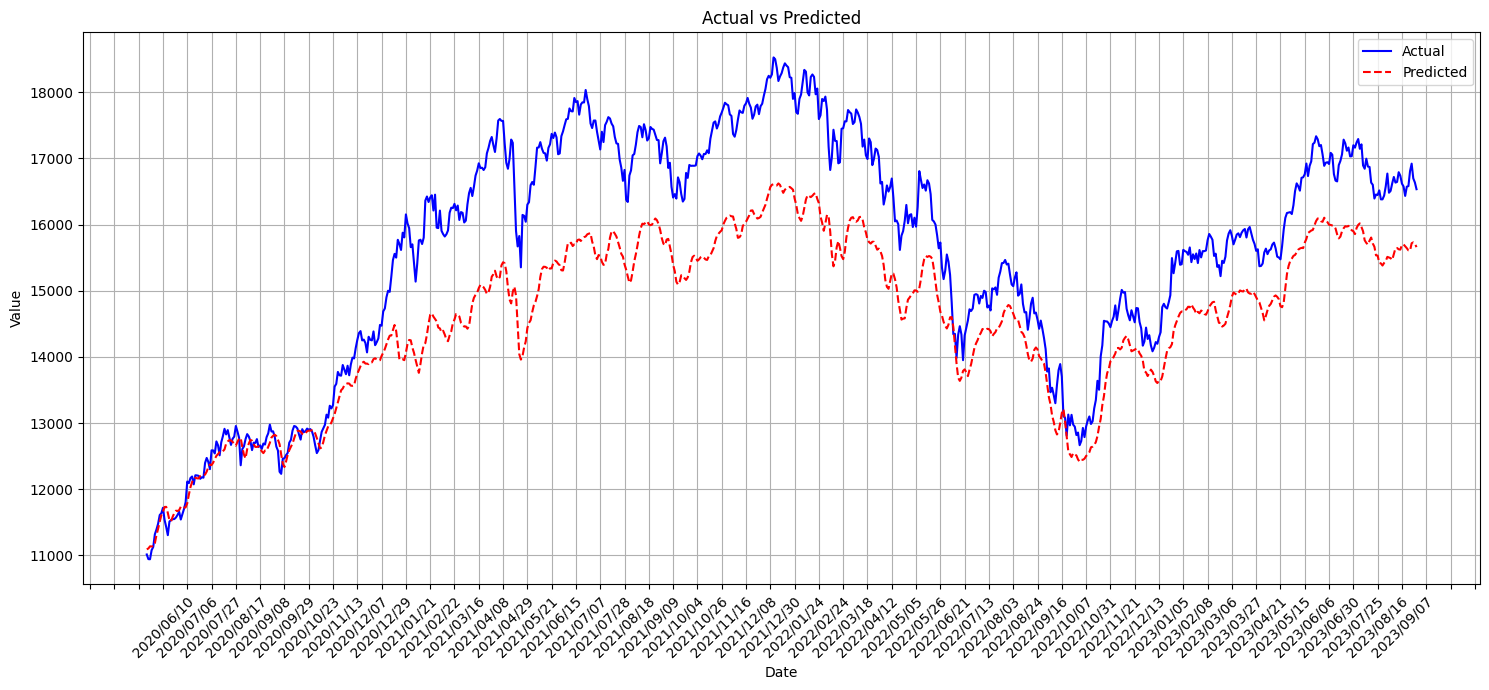

In [131]:
df = pd.read_csv('../data/row_data.csv')
dates = df['date'].values[-len(y_test):]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test_denorm, label="Actual", color='blue')
plt.plot(dates, predictions_denorm, label="Predicted", color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.tight_layout()
plt.show()

In [127]:
model.save("LSTM_tomorrow.h5")

c:\Users\overf\anaconda3\envs\StockMarketIndexAI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
